<a href="https://colab.research.google.com/github/CraftyManiac/Music-Classification/blob/main/Music_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Music Classification

(TODO) about this

#Working Directory
Change current working directory to where Project is stored, this may need to be different if you're using jupyter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "drive/Shared drives/CMPT 399 Erwin_Laroy"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shared drives/CMPT 399 Erwin_Laroy


#Imports

In [ ]:
%load_ext tensorboard

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
# heatmaps for the confusion matrix
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
import datetime, os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Helper Functions

In [ ]:
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def plot_Confusion_matrix(cm, title=None, categories=[0,1]):
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in
                  cm.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in
                      cm.flatten()/np.sum(cm)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  plt.figure(figsize=(6,6))
  sn.heatmap(cm,annot=labels ,fmt="", xticklabels=categories, yticklabels=categories)
  plt.xlabel('Predicted')
  plt.ylabel('Truth')
  plt.title(title)
  plt.show()

In [ ]:
def plot_multi_confusion_matrix(cf, title=None, categories=[0,1,2,3,4]):
  group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]

  box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_counts,group_percentages)]
  box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

  plt.figure(figsize=(8,8))
  
  sn.heatmap(cf,annot=box_labels ,fmt="", xticklabels=categories, yticklabels=categories)
  plt.xlabel('Predicted')
  plt.ylabel('Truth')
  plt.title(title)
  plt.show()

In [ ]:
# Prints preccision-recall and accuracy metrics
def print_recall(model, XTest, yTest, yPredict, avg='binary'):
  print("Accuracy: {0:.2f}".format(model.score(XTest, yTest)))

  precision = metrics.precision_score(y_true=yTest, y_pred=yPredict, average=avg)
  print('Precision score: {0:.2f}'.format(precision))

  recall = metrics.recall_score(y_true=yTest, y_pred=yPredict, average=avg)
  print('Recall score: {0:.2f}'.format(recall))

  f1 = 2 * (precision * recall) / (precision + recall)
  print('F1 score: {0:.2f}'.format(recall))

In [ ]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# This function finds the best hyperparameters for Random Forest using a random search
def best_random_search(XTrain, yTrain):
  n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

  max_features = ['auto', 'sqrt']

  max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
  max_depth.append(None)

  min_samples_split = [2, 5, 10]

  min_samples_leaf = [1, 2, 4]

  bootstrap = [True, False]

  random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}

  rnd_clf = RandomForestClassifier()
  rf_random = RandomizedSearchCV(estimator = rnd_clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
  rf_random.fit(XTrain, yTrain)
  print('\nBest parameters:', rf_random.best_params_)
  return rf_random

In [ ]:
def plot_learning_curves(model, X_train, y_train, X_val, y_val, title):
  train_errors, val_errors = [], []
  for m in range(4, len(X_train)):
    model.fit(X_train[:m], np.ravel(y_train[:m]))
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(metrics.mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(metrics.mean_squared_error(y_val, y_val_predict))
  plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label='train')
  plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label='val')
  plt.xlabel('Training set size')
  plt.ylabel('RMSE')
  plt.legend()
  plt.title(title)



# Test Midi File

In [ ]:
data = pd.read_csv('Tchaikovsky.csv', sep=',', index_col=False)
tchaikovsky = data.drop(columns=['Composer'])

#Data Set 1
Binary classification:  
- 0 = Mozart (100 midi files)
- 1 = Chopin (100 midi files)

In [ ]:
data = pd.read_csv('data_set_1.csv', sep=',', index_col=False)

X, y1 = data.drop(columns=['Composer']), data['Composer']

labels = y1.unique()
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder 
# This turns string labels into one-hot encoding
encoder = LabelBinarizer()
y = encoder.fit_transform(y1)


print(X.shape, y.shape)
# Split the data between test and train sets
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.20, random_state=42)

(200, 162) (200, 1)


##Stochastic Gradient Descent Classifier

In [ ]:
# Stochastic Gradient Descent Clasifier

sgd_clf = SGDClassifier(alpha=0.00001, epsilon=0.1, learning_rate='adaptive', eta0=0.001,  validation_fraction=0.1, random_state=42)
sgd_clf.fit(XTrain, np.ravel(yTrain))
yScore = sgd_clf.decision_function(XTest)

In [ ]:
y_predict = sgd_clf.predict(XTest)

print_recall(sgd_clf, XTest, yTest, y_predict)

avgPrecision = metrics.average_precision_score(yTest, yScore)
print('Average precision recall score: {0:.2f}'.format(avgPrecision))

Accuracy: 0.85
Precision score: 0.83
Recall score: 0.90
F1 score: 0.90
Average precision recall score: 0.76


Text(0.5, 1.0, '2-class SGD Precision-Recall curve: AP=0.76')

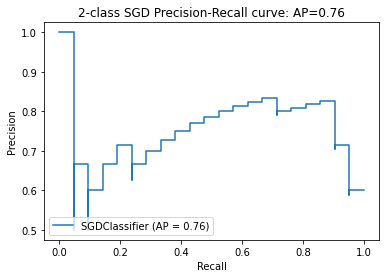

In [ ]:
disp = metrics.plot_precision_recall_curve(sgd_clf, XTest, yTest)
disp.ax_.set_title('2-class SGD Precision-Recall curve: '
                   'AP={0:0.2f}'.format(avgPrecision))

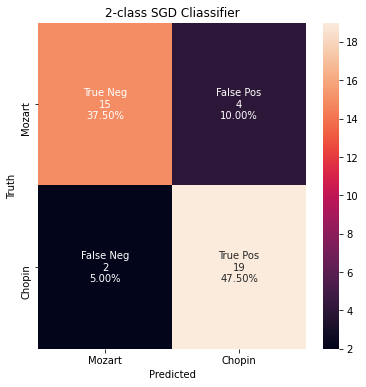

In [ ]:
cm = confusion_matrix(yTest, y_predict)
plot_Confusion_matrix(cm, title='2-class SGD Cliassifier', categories=labels)

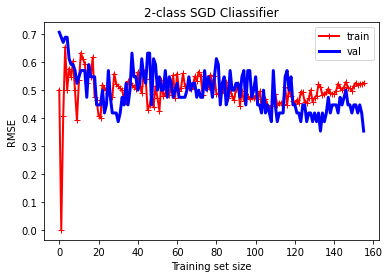

In [ ]:
plot_learning_curves(sgd_clf, XTrain, yTrain, XTest, yTest, '2-class SGD Cliassifier')

In [ ]:
print("Tchaikovsky's Nutcracker is most similar to", labels[sgd_clf.predict(tchaikovsky)])

Tchaikovsky's Nutcracker is most similar to ['Mozart']


## Random Forest Classifier

In [ ]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(XTrain, np.ravel(yTrain))


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
yPredict = base_model.predict(XTest)

print_recall(base_model, XTest, yTest, yPredict)
yScore = base_model.predict_proba(XTest)

Accuracy: 0.80
Precision score: 0.76
Recall score: 0.90
F1 score: 0.90


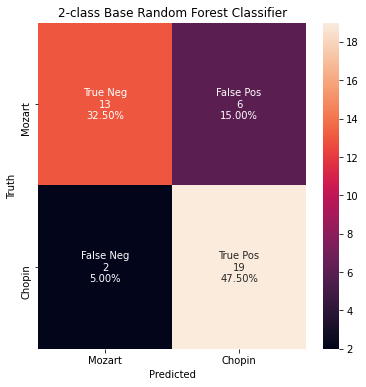

In [ ]:
cm = confusion_matrix(yTest, yPredict)
plot_Confusion_matrix(cm, title='2-class Base Random Forest Classifier', categories=labels)

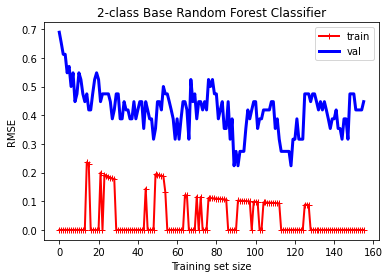

In [ ]:
plot_learning_curves(base_model, XTrain, yTrain, XTest, yTest, '2-class Base Random Forest Classifier')

In [ ]:
print("Tchaikovsky's Nutcracker is most similar to", labels[base_model.predict(tchaikovsky)])

Tchaikovsky's Nutcracker is most similar to ['Mozart']


###Hyperparameter Tuning

In [ ]:
best_random = best_random_search(XTrain, yTrain)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)



Best parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': False}


In [ ]:
yPredictBest = best_random.predict(XTest)

print_recall(best_random, XTest, yTest, yPredictBest)

Accuracy: 0.90
Precision score: 0.87
Recall score: 0.95
F1 score: 0.95


In [ ]:
print(best_random.best_params_)

{'n_estimators': 1200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}


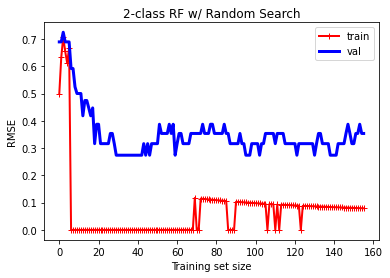

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=1200, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', max_depth=20, bootstrap=False)
# rnd_clf = RandomForestClassifier(n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features='auto', max_depth=50, bootstrap=False)
rnd_clf.fit(XTest, np.ravel(yTest))

plot_learning_curves(rnd_clf, XTrain, yTrain, XTest, yTest, '2-class RF w/ Random Search')

Accuracy: 0.88
Precision score: 0.83
Recall score: 0.95
F1 score: 0.95


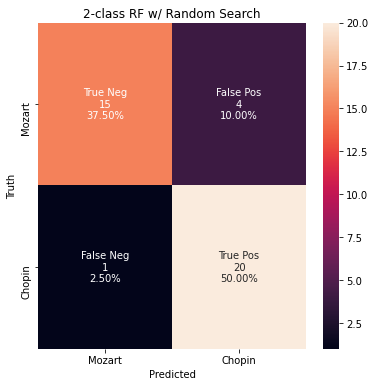

In [ ]:

y_new = rnd_clf.predict(XTest)
print_recall(rnd_clf, XTest, yTest, y_new)

cm = confusion_matrix(yTest, y_new)
plot_Confusion_matrix(cm, title='2-class RF w/ Random Search', categories=labels)


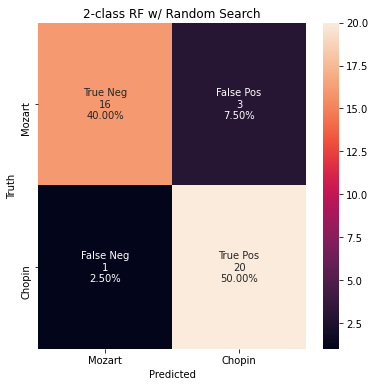

In [ ]:
cm = confusion_matrix(yTest, yPredictBest)
plot_Confusion_matrix(cm, title='2-class RF w/ Random Search', categories=labels)

In [ ]:
# plot_learning_curves(best_random, XTrain, yTrain, XTest, yTest, '2-class RF w/ Random Search')

In [ ]:
print("Tchaikovsky's Nutcracker is most similar to", labels[rnd_clf.predict(tchaikovsky)])

Tchaikovsky's Nutcracker is most similar to ['Mozart']


###Feature Importance

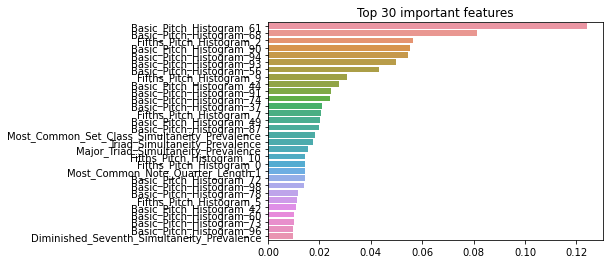

In [ ]:
feature_imp = pd.Series(base_model.feature_importances_, index=list(data.drop('Composer', 1))).sort_values(ascending=False)

sn.barplot(x=feature_imp[:30], y=feature_imp[:30].index)
plt.title('Top 30 important features')
plt.show()

#Data Set 2

In [ ]:
data = pd.read_csv('data_set_2.csv', sep=',', index_col=False)

X, y1 = data.drop(columns=['Composer']), data['Composer']

labels = y1.unique()

encoder = LabelEncoder()
y = encoder.fit_transform(y1)


print(X.shape, y.shape)
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.20, random_state=42)

(500, 162) (500,)


##Stochastic Gradient Descent Classifier

In [ ]:
sgd_clf = SGDClassifier(alpha=0.1, epsilon=0.001, learning_rate='adaptive', eta0=0.00001,  validation_fraction=0.1, random_state=42)
sgd_clf.fit(XTrain, np.ravel(yTrain))
yScore = sgd_clf.decision_function(XTest)

In [ ]:
y_predict = sgd_clf.predict(XTest)

print_recall(sgd_clf, XTest, yTest, y_predict, avg='micro')

Accuracy: 0.45
Precision score: 0.45
Recall score: 0.45
F1 score: 0.45


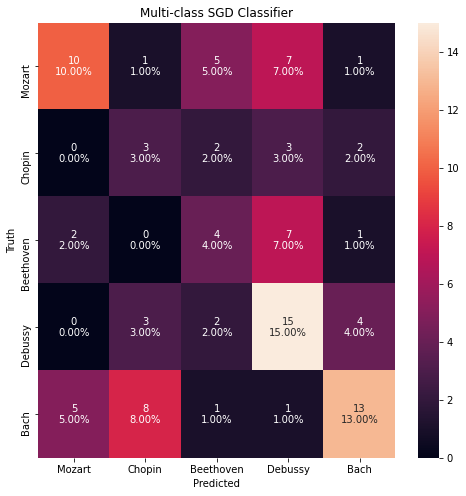

In [ ]:
cm = confusion_matrix(yTest, y_predict)
plot_multi_confusion_matrix(cm, title='Multi-class SGD Classifier', categories=labels)

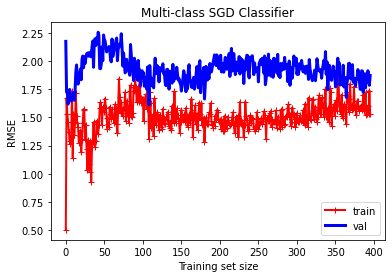

In [ ]:
plot_learning_curves(sgd_clf, XTrain, yTrain, XTest, yTest, 'Multi-class SGD Classifier')

In [ ]:
print("Tchaikovsky's Nutcracker is most similar to", labels[sgd_clf.predict(tchaikovsky)])

Tchaikovsky's Nutcracker is most similar to ['Debussy']


##Logistic Regression Classifier
Clearly Stochastic gradient will not work for our multiclass classifier

In [ ]:
LRModel = LogisticRegression(C=10, random_state=42, solver='newton-cg').fit(XTrain, yTrain)

y_predict = LRModel.predict(XTest)

print_recall(LRModel, XTest, yTest, y_predict, avg='micro')


Accuracy: 0.72
Precision score: 0.72
Recall score: 0.72
F1 score: 0.72


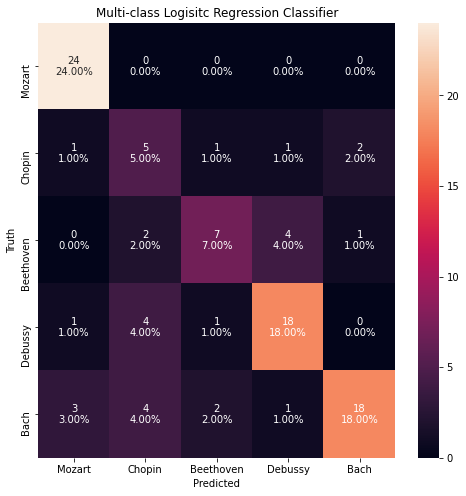

In [ ]:
cm = confusion_matrix(yTest, y_predict)
plot_multi_confusion_matrix(cm, title='Multi-class Logisitc Regression Classifier', categories=labels)

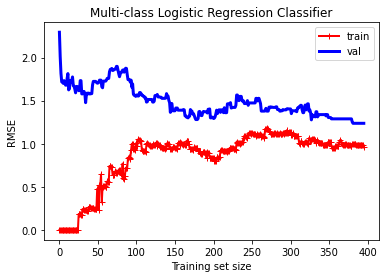

In [ ]:
plot_learning_curves(LRModel, XTrain, yTrain, XTest, yTest, 'Multi-class Logistic Regression Classifier')

In [ ]:
print("Tchaikovsky's Nutcracker is most similar to", labels[LRModel.predict(tchaikovsky)])

Tchaikovsky's Nutcracker is most similar to ['Bach']


##Random Forest Classifier

In [ ]:
rnd_clf1 = RandomForestClassifier(n_estimators=100, random_state=42).fit(XTrain, yTrain)

y_pred_rf = rnd_clf1.predict(XTest)

print_recall(rnd_clf1, XTest, yTest, y_pred_rf, avg='micro')



Accuracy: 0.85
Precision score: 0.85
Recall score: 0.85
F1 score: 0.85


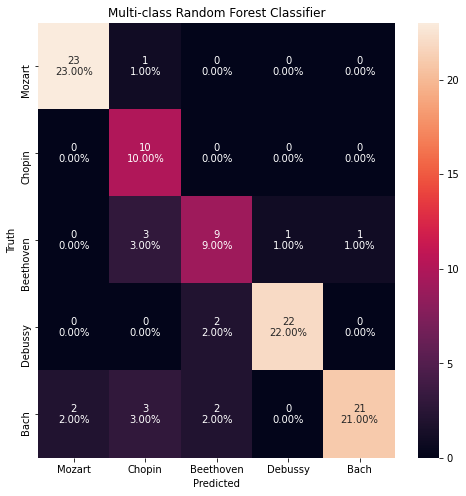

In [ ]:
cm = confusion_matrix(yTest, y_pred_rf)
plot_multi_confusion_matrix(cm, title='Multi-class Random Forest Classifier', categories=labels)

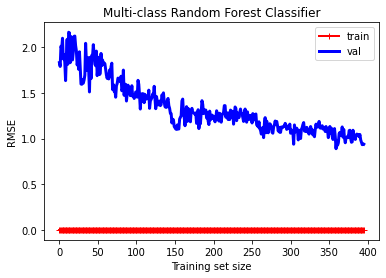

In [ ]:
plot_learning_curves(rnd_clf1, XTrain, yTrain, XTest, yTest, 'Multi-class Random Forest Classifier')

In [ ]:
print("Tchaikovsky's Nutcracker is most similar to", labels[rnd_clf1.predict(tchaikovsky)])

Tchaikovsky's Nutcracker is most similar to ['Beethoven']


###Hyperparameter Tuning

In [ ]:
best_random = best_random_search(XTrain, yTrain)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.5min finished



Best parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': False}


In [ ]:
yPredictBest = best_random.predict(XTest)

print_recall(best_random, XTest, yTest, yPredictBest, avg='micro')

Accuracy: 0.86
Precision score: 0.86
Recall score: 0.86
F1 score: 0.86


In [ ]:
yPredictBest = best_random.best_estimator_.predict(XTest)

print_recall(best_random, XTest, yTest, yPredictBest, avg='micro')

Accuracy: 0.86
Precision score: 0.86
Recall score: 0.86
F1 score: 0.86


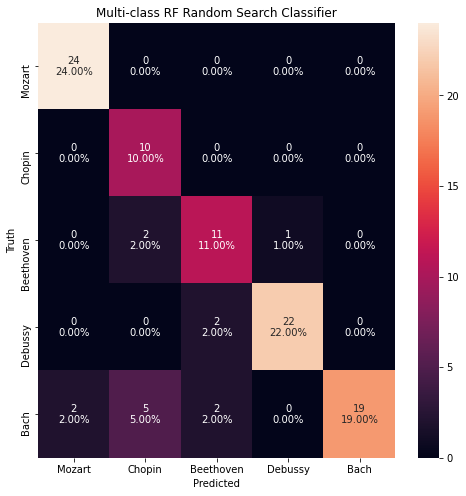

In [ ]:
cm = confusion_matrix(yTest, yPredictBest)
plot_multi_confusion_matrix(cm, title='Multi-class RF Random Search Classifier', categories=labels)

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features='auto', max_depth=90, bootstrap=False)
# rnd_clf = RandomForestClassifier(n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features='auto', max_depth=50, bootstrap=False)
rnd_clf.fit(XTest, np.ravel(yTest))
y_new = rnd_clf.predict(XTest)

Accuracy: 0.86
Precision score: 0.86
Recall score: 0.86
F1 score: 0.86


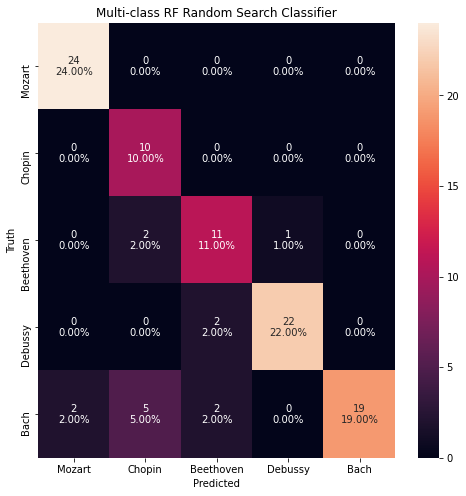

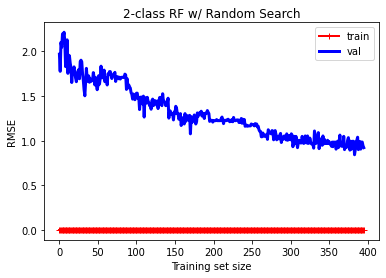

In [ ]:
print_recall(best_random.best_estimator_, XTest, yTest, yPredictBest, avg='micro')
cm = confusion_matrix(yTest, yPredictBest)
plot_multi_confusion_matrix(cm, title='Multi-class RF Random Search Classifier', categories=labels)
plot_learning_curves(best_random.best_estimator_, XTrain, yTrain, XTest, yTest, '2-class RF w/ Random Search')

In [ ]:
print("Tchaikovsky's Nutcracker is most similar to", labels[best_random.predict(tchaikovsky)])
print("Tchaikovsky's Nutcracker is most similar to", labels[rnd_clf.predict(tchaikovsky)])

Tchaikovsky's Nutcracker is most similar to ['Beethoven']
Tchaikovsky's Nutcracker is most similar to ['Beethoven']


###Feature Importance

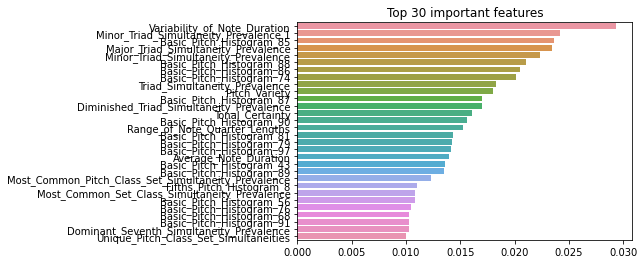

In [ ]:
feature_imp = pd.Series(rnd_clf1.feature_importances_, index=list(data.drop('Composer', 1))).sort_values(ascending=False)

sn.barplot(x=feature_imp[:30], y=feature_imp[:30].index)
plt.title('Top 30 important features')
plt.show()

##NN

In [ ]:
# This turns string labels into ints
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
yTrain_new = encoder.fit_transform(yTrain)


In [ ]:
from functools import partial

regularize_dense = partial(keras.layers.Dense, activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01))


In [ ]:
# nn_model2 = keras.models.Sequential([keras.layers.Flatten(),
#                                    keras.layers.Dense(25, activation='relu'),
#                                    #keras.layers.Dense(50, activation='relu'),
#                                    keras.layers.Dense(5, activation='softmax')])

nn_model2 =keras.models.Sequential([keras.layers.Flatten(),
                                    regularize_dense(200),
                                    regularize_dense(100),
                                    regularize_dense(5, activation='softmax', kernel_initializer='glorot_uniform')])


nn_model2.compile(loss='sparse_categorical_crossentropy',
                 optimizer=keras.optimizers.Adam(learning_rate=0.001), # p303 change the optimizer
                 metrics=['accuracy'])
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logs_base_dir, histogram_freq=1)

history = nn_model2.fit(XTrain, yTrain_new, epochs=2000, validation_split=0.1, use_multiprocessing=True)

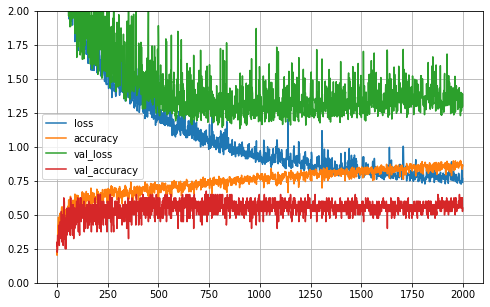

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.ylim(0,2)
plt.show()

#Citations:
http://web.mit.edu/music21/papers/Cuthbert_Ariza_Friedland_Feature-Extraction_ISMIR_2011.pdf